<a href="https://colab.research.google.com/github/C191248TahiaHoque/Neural-Network-Projects/blob/main/Group_05_NN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prediction of eltricity consumption using RNN**

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as state
import pprint
%matplotlib inline
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

#check all the files in the input dataset
#print(os.listdir("../input/"))

In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # special style template for matplotlib, highly useful for visualizing time series data
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Loading data

In [3]:
fpath='DOM_hourly.csv'

df=pd.read_csv(fpath)
df.head()


,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


Change the index of rows in the dataframe from 0,1,2... to datetime (2005-12-31 01:00:00,...)
Why should we change the index of rows?
Because we are dealing with time series data and we will need the datetime data to recognize a particular record.

**1. Data Preprocessing**

In [4]:
#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [5]:
# Information about Dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116189 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DOM_MW  116189 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB
None


In [6]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

Since there is no missing data in the data loaded we will not be dropping the missing value records or will not be imputing the data. We will proceed with the further data analysis.

**2. Data visualization**

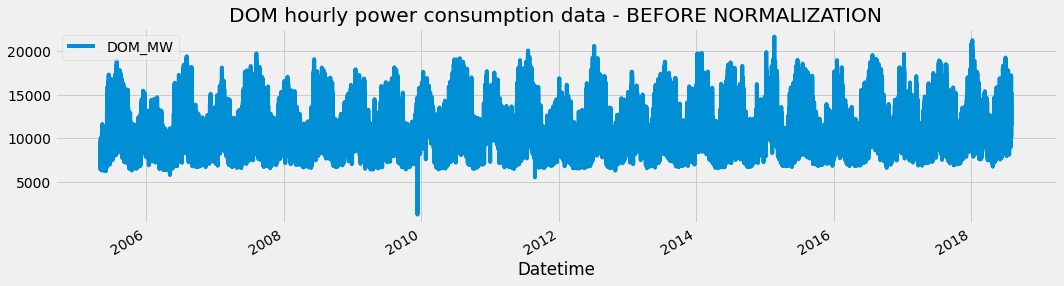

In [7]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

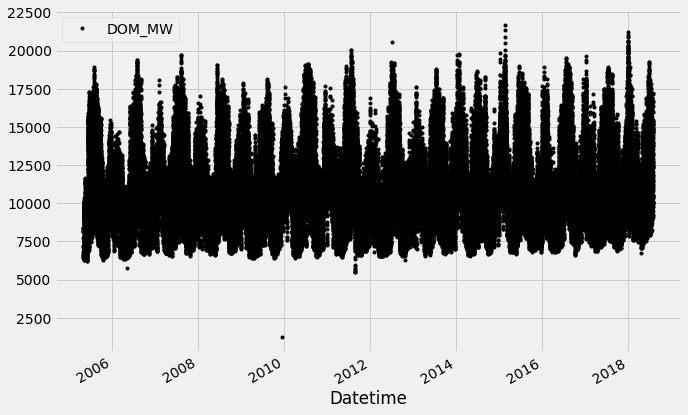

In [8]:
#scatter plot
df.plot(style='k.')
plt.show()

<Axes: ylabel='Density'>

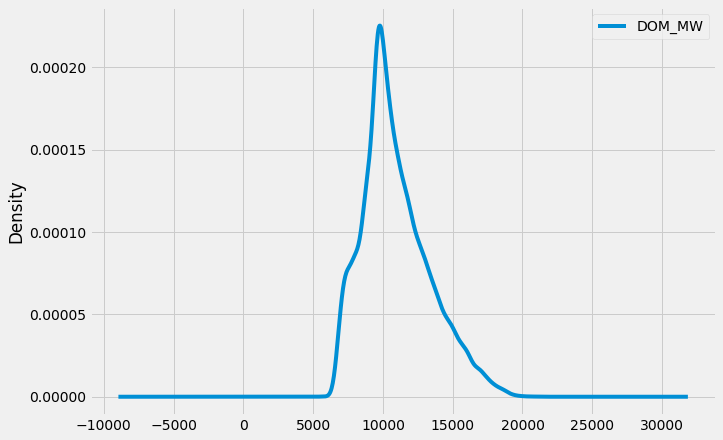

In [9]:
df.plot(kind='kde')
#distribution chart

**Histogram**

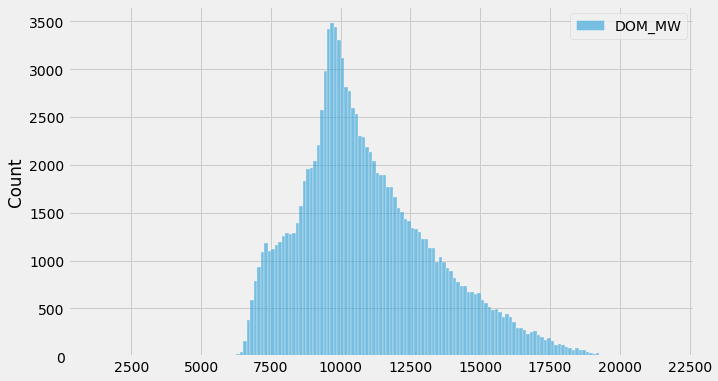

In [10]:
sns.histplot(df).figure.set_size_inches(10, 6)

**Histogram and Distribution chart**

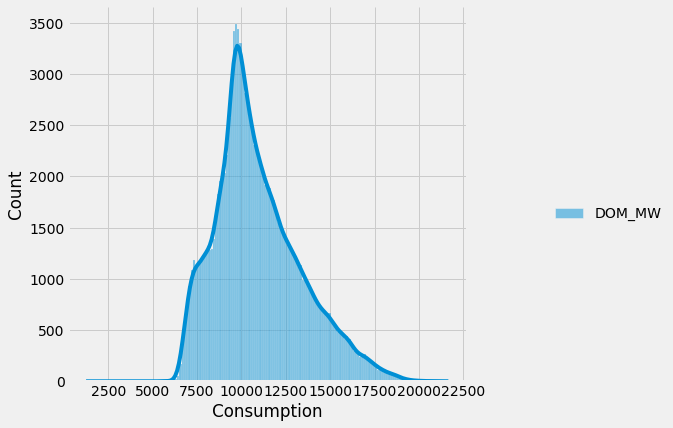

In [11]:
sns.displot(df, kde=True).figure.set_size_inches(10, 6)
plt.xlabel('Consumption')
plt.show()

**3. Normalize data**

Before proceeding with further data analysis we must ensure that the data is normalized.
For this we will be using sklearn MinMaxScaler

In [12]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

**Visualize data after normalization**
After normalization the range of power consumption values changes which we can observe on the y-axis of the graph. In the earlier graph that was displayed it was in the range 0 - 22500
Now after normalization we can observe that the data range on y-axis is 0.0 - 1.0

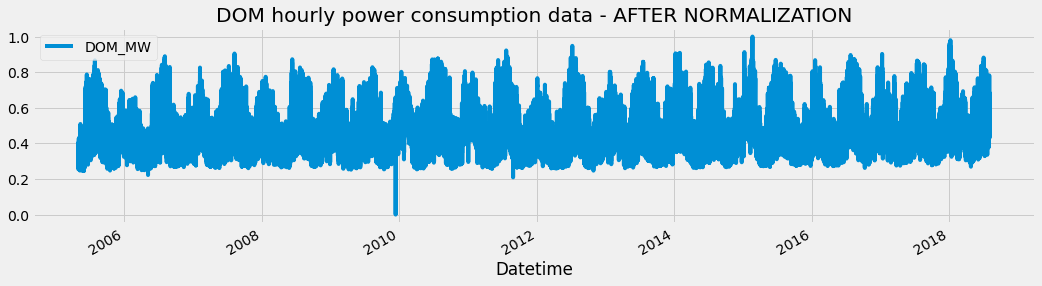

In [13]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [14]:
df_norm.shape

(116189, 1)

**4. Stationarising the time series.**

First, we need to check if a series is stationary or not.

ADF (Augmented Dickey-Fuller) Test The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

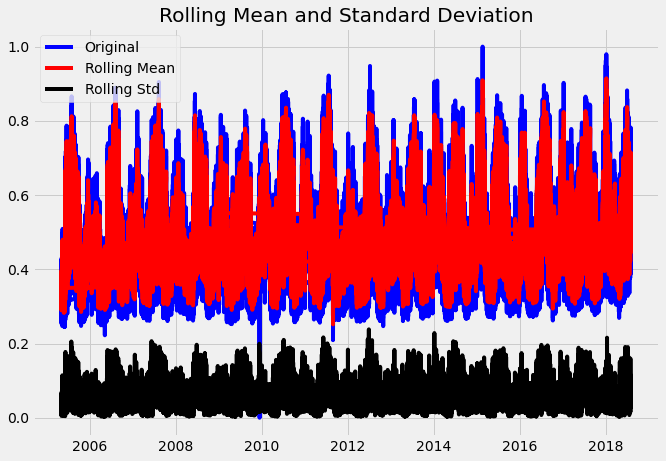

Results of dickey fuller test
Test Statistics               -1.500691e+01
p-value                        1.069441e-27
No. of lags used               7.100000e+01
Number of observations used    1.161170e+05
critical value (1%)           -3.430406e+00
critical value (5%)           -2.861565e+00
critical value (10%)          -2.566783e+00
dtype: float64


In [15]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['DOM_MW'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.The test statistics is greater than the critical values. so the data is non-stationary.

To get a stationary series, we need to eliminate the trend and seasonality from the series.

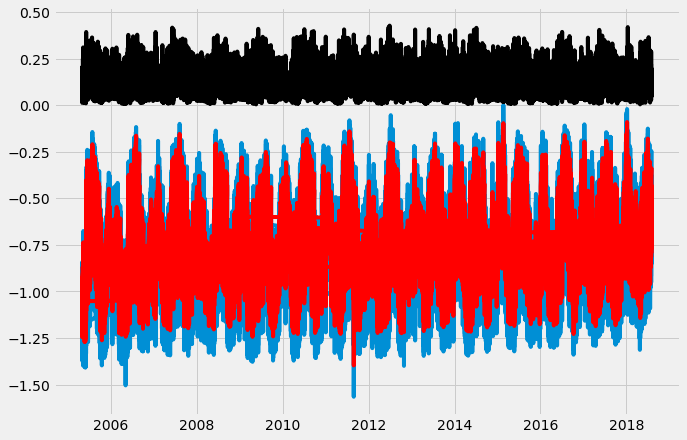

In [16]:
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

After finding the mean, we take the difference of the series and the mean at every point in the series.

This way, we eliminate trends out of a series and obtain a more stationary series.



In [17]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

Perform the Dickey-Fuller test (ADFT) once again. We have to perform this function every time to check whether the data is stationary or not.

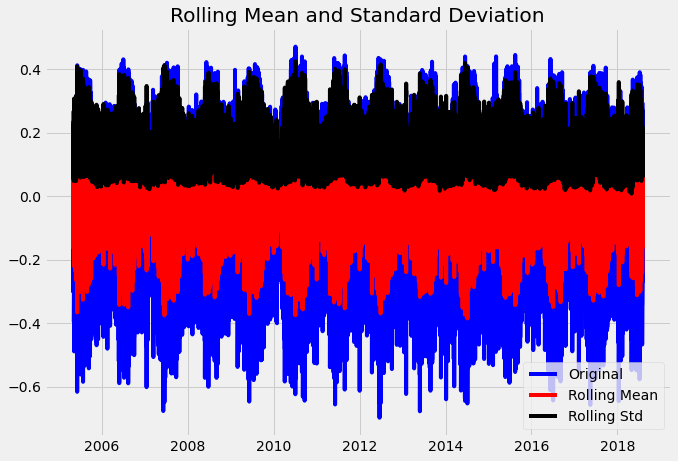

Results of dickey fuller test
Test Statistics                   -42.761693
p-value                             0.000000
No. of lags used                   71.000000
Number of observations used    116094.000000
critical value (1%)                -3.430406
critical value (5%)                -2.861565
critical value (10%)               -2.566783
dtype: float64


In [18]:
test_stationarity(df_log_moving_avg_diff)

From the above graph, we observed that the data attained stationarity.

One of the modules is completed as we came to a conclusion. We need to check the weighted average, to understand the trend of the data in time series. Take the previous log data and to perform the following operation.

In [19]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

The exponential moving average (EMA) is a weighted average of the last n prices, where the weighting decreases exponentially with each previous price/period

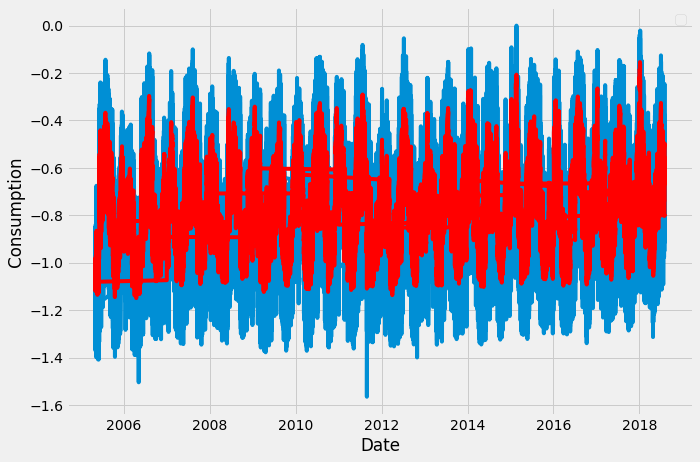

In [20]:
plt.plot(df_log)
plt.plot(weighted_average, color='red')
plt.xlabel("Date")
plt.ylabel("Consumption")
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
plt.legend()
plt.show(block =False)

**Function for checking the stationarity of Time Series**

In [21]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    sns.lineplot(y=df,x=df.index,)
    df.rolling(window=12).mean().plot()
    df.rolling(window=12).std().plot()
    result=adfuller(df,autolag="AIC")

    print(f"ADF Statistics: {result[0]}")
    print(f"p value: {result[1]}")

    for key,value in result[4].items():
        print(f"Critical Value {key}: {value}") 
        
    print("\n\n")

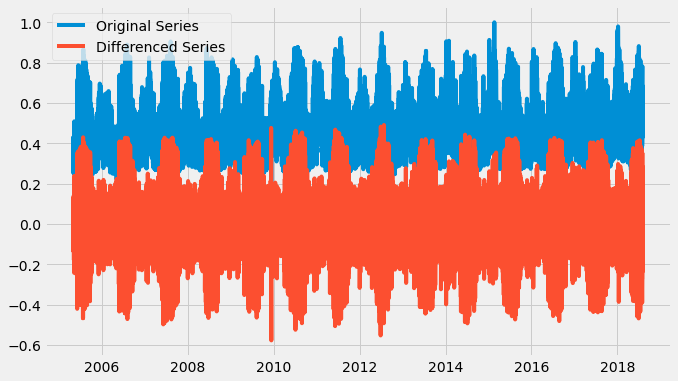

In [22]:
diff_12=df["DOM_MW"].diff(12).dropna()

plt.plot(df["DOM_MW"],label="Original Series")
plt.plot(diff_12,label="Differenced Series")
plt.legend(loc="upper left")

ADF Statistics: -15.006910125497788
p value: 1.0694412696233548e-27
Critical Value 1%: -3.4304063177189126
Critical Value 5%: -2.8615648915875043
Critical Value 10%: -2.5667832489143803





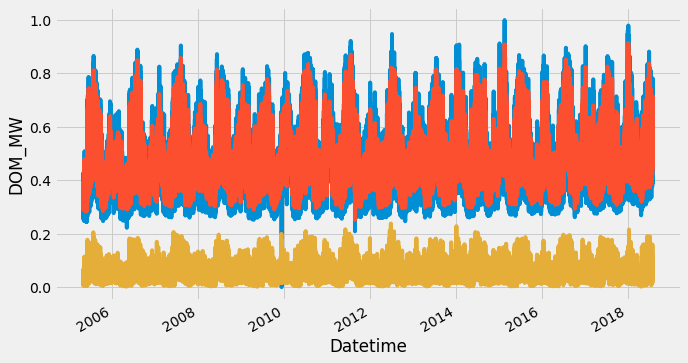

In [23]:
check_stationarity(df["DOM_MW"])

**5. Prepare data for training the RNN models**


In [24]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [25]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


**6. Build a RNN mode**

In [26]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [27]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 13s 89ms/step - loss: 0.1560
Epoch 2/10
110/110 [==============================] - 9s 85ms/step - loss: 0.0241
Epoch 3/10
110/110 [==============================] - 15s 141ms/step - loss: 0.0122
Epoch 4/10
110/110 [==============================] - 14s 125ms/step - loss: 0.0080
Epoch 5/10
110/110 [==============================] - 11s 99ms/step - loss: 0.0059
Epoch 6/10
110/110 [==============================] - 8s 74ms/step - loss: 0.0047
Epoch 7/10
110/110 [==============================] - 8s 69ms/step - loss: 0.0038
Epoch 8/10
110/110 [==============================] - 8s 71ms/step - loss: 0.0033
Epoch 9/10
110/110 [==============================] - 8s 68ms/step - loss: 0.0029
Epoch 10/10
110/110 [==============================] - 8s 73ms/step - loss: 0.0026


Let's check r2 score for the values predicted by the above trained SIMPLE RNN model

In [28]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

193/193 [==============================] - 1s 3ms/step
R2 Score of RNN model =  0.9481877440364831


Let's compare the actual values vs predicted values by plotting a graph
We see that the predcited values are close to the actual values meaning the RNN model is performing well in predicting the sequence.

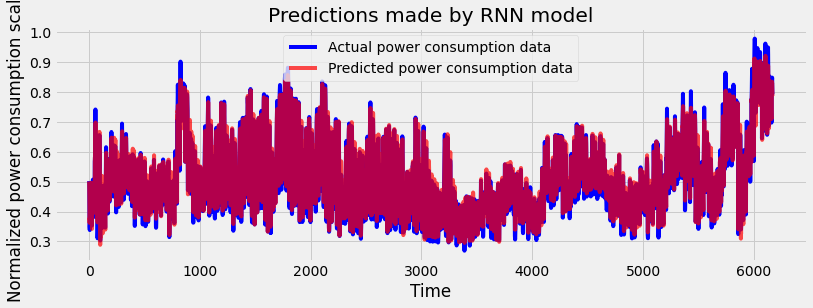

In [32]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(12,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='red',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by RNN model")

**7. Build an LSTM model**

In [33]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [34]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 23s 168ms/step - loss: 0.0250
Epoch 2/10
110/110 [==============================] - 18s 167ms/step - loss: 0.0120
Epoch 3/10
110/110 [==============================] - 18s 161ms/step - loss: 0.0081
Epoch 4/10
110/110 [==============================] - 19s 169ms/step - loss: 0.0052
Epoch 5/10
110/110 [==============================] - 19s 173ms/step - loss: 0.0043
Epoch 6/10
110/110 [==============================] - 20s 181ms/step - loss: 0.0033
Epoch 7/10
110/110 [==============================] - 19s 174ms/step - loss: 0.0027
Epoch 8/10
110/110 [==============================] - 18s 164ms/step - loss: 0.0023
Epoch 9/10
110/110 [==============================] - 19s 170ms/step - loss: 0.0020
Epoch 10/10
110/110 [==============================] - 18s 166ms/step - loss: 0.0019


Let's check r2 score for the values predicted by the above trained LSTM mode

In [35]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

193/193 [==============================] - 3s 8ms/step
R^2 Score of LSTM model =  0.9398773115766019


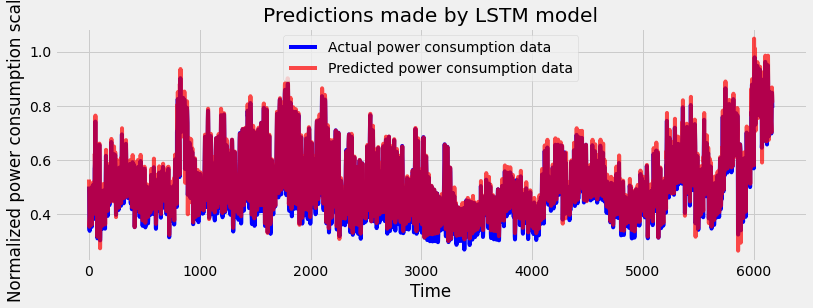

In [36]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

**8. Compare predictions made by simple RNN, LSTM model by plotting data in a single graph**

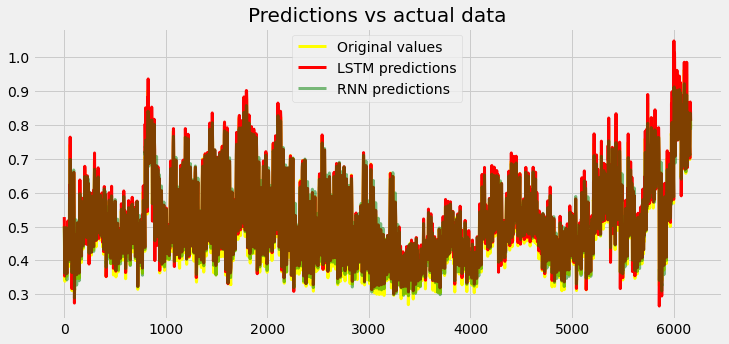

In [40]:
plt.figure(figsize=(11,5))

plt.plot(y_test, c="yellow", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

**9. Consumtion Time series for year ,month and day of the week**

In [41]:
df1 = df
df1["Year"]=df1.index.year
df1["Month"]=df1.index.month
df1["Day_of_week"]=df1.index.dayofweek
df1.head()

,DOM_MW,Year,Month,Day_of_week
Datetime,,,,
2005-12-31 01:00:00,0.398863,2005,12,5
2005-12-31 02:00:00,0.383224,2005,12,5
2005-12-31 03:00:00,0.379841,2005,12,5
2005-12-31 04:00:00,0.381851,2005,12,5
2005-12-31 05:00:00,0.386263,2005,12,5


In [42]:
plt.rcParams.update({"figure.figsize":(12,8)})

<Axes: title={'center': 'Consumption Time Series'}, xlabel='Datetime', ylabel='DOM_MW'>

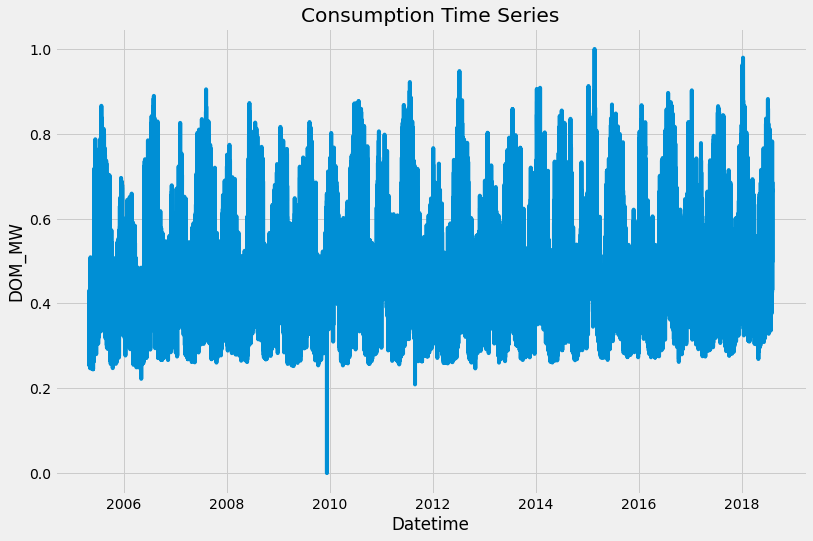

In [44]:
plt.title("Consumption Time Series")
sns.lineplot(y=df["DOM_MW"],x=df.index)

**Yearly electricity consumption**

<Axes: xlabel='Year', ylabel='DOM_MW'>

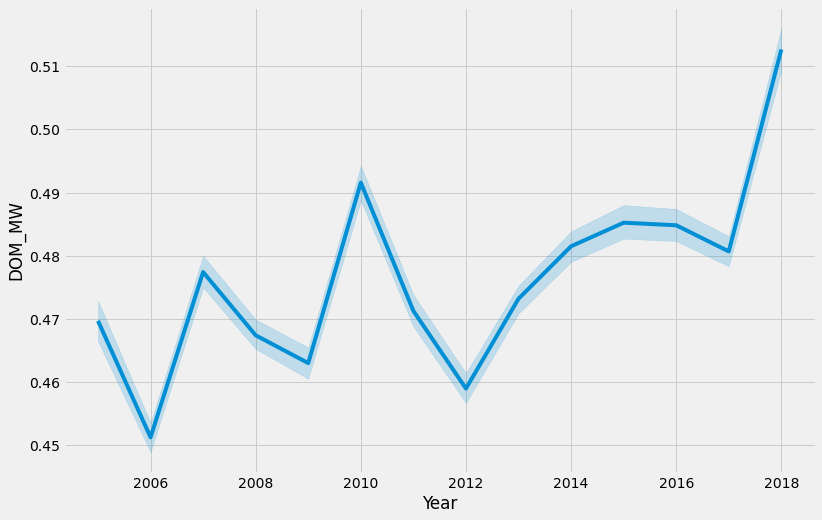

In [45]:
sns.lineplot(x="Year",y="DOM_MW",data=df)

The amount of yearly comsumption finally increases.

**Feature understanding for yearly consumption**

In this section, the exploration of the distribution of electricity demand with respect the different features will be shown as it is a great way to understand the seasonalities in the time series.

<Axes: xlabel='Year', ylabel='DOM_MW'>

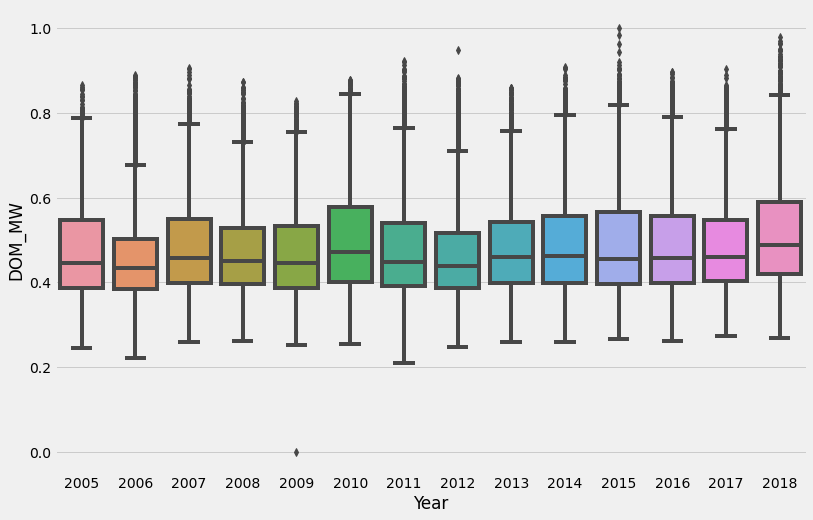

In [46]:
sns.boxplot(x="Year",y="DOM_MW",data=df)

**Monthly electricity consumption**

<Axes: xlabel='Month', ylabel='DOM_MW'>

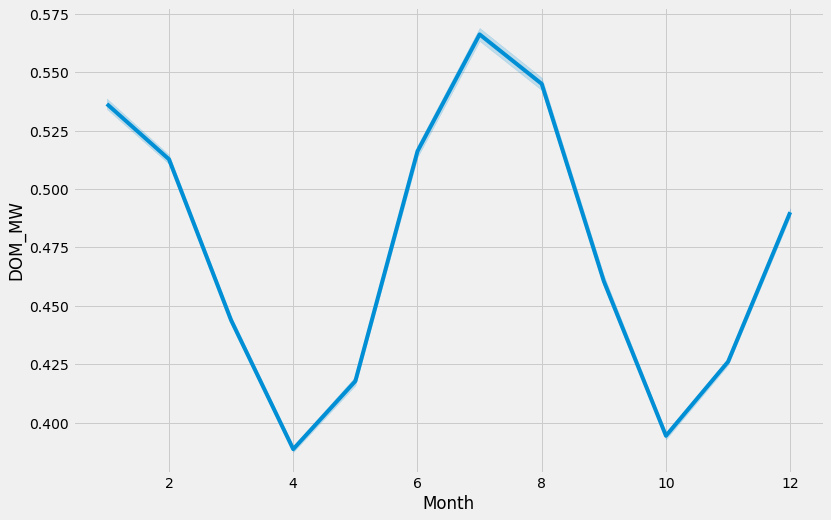

In [47]:
sns.lineplot(x="Month",y="DOM_MW",data=df)

There is strong monthly seasonality as the trend is sometimes upward and sometimes downward.

**Feature understanding for monthly consumption**

<Axes: xlabel='Month', ylabel='DOM_MW'>

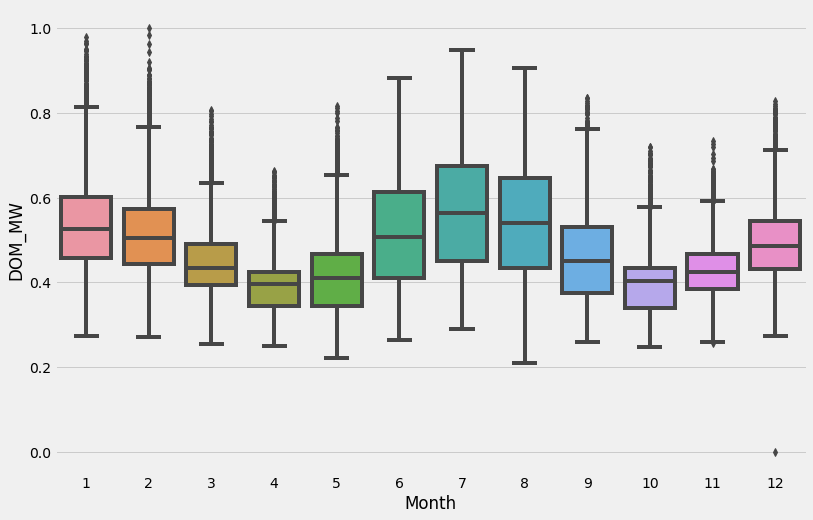

In [49]:
sns.boxplot(x="Month",y="DOM_MW",data=df)

**Cosumption of day of the week**

<Axes: xlabel='Day_of_week', ylabel='DOM_MW'>

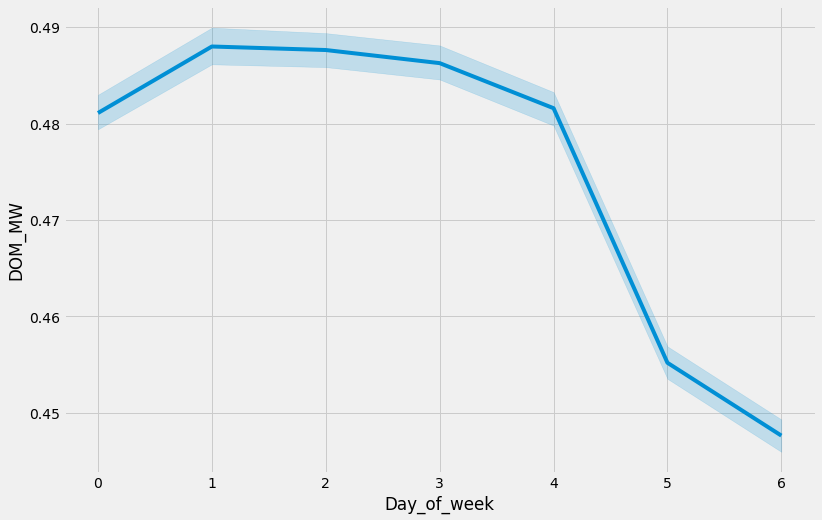

In [50]:
sns.lineplot(x="Day_of_week",y="DOM_MW",data=df)

**Feature understanding for the consumption of day of week**

<Axes: xlabel='Day_of_week', ylabel='DOM_MW'>

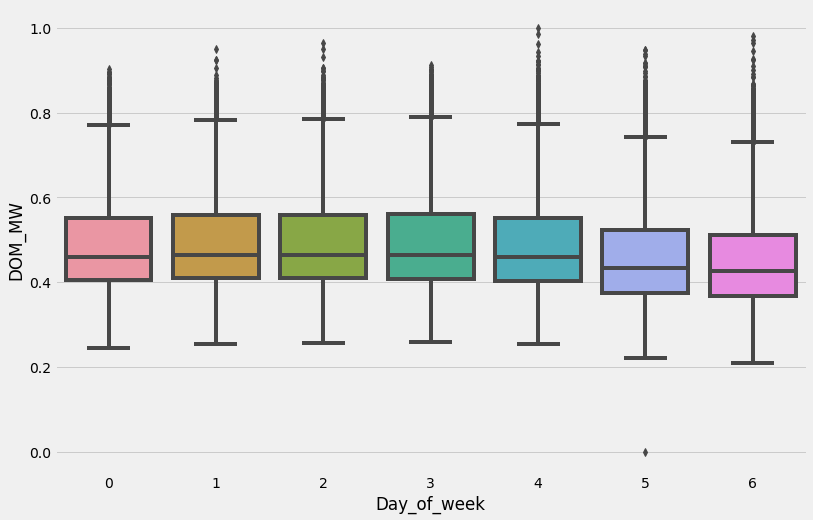

In [51]:
sns.boxplot(x="Day_of_week",y="DOM_MW",data=df)

In [52]:
print(df.describe())

              DOM_MW           Year          Month    Day_of_week
count  116189.000000  116189.000000  116189.000000  116189.000000
mean        0.475351    2011.459088       6.514025       2.998890
std         0.118342       3.845824       3.417708       1.999959
min         0.000000    2005.000000       1.000000       0.000000
25%         0.395578    2008.000000       4.000000       1.000000
50%         0.453378    2011.000000       7.000000       3.000000
75%         0.545397    2015.000000       9.000000       5.000000
max         1.000000    2018.000000      12.000000       6.000000


**Energy distribution for year,month,day_of_weak**

Text(0.5, 1.0, 'Energy Distribution')

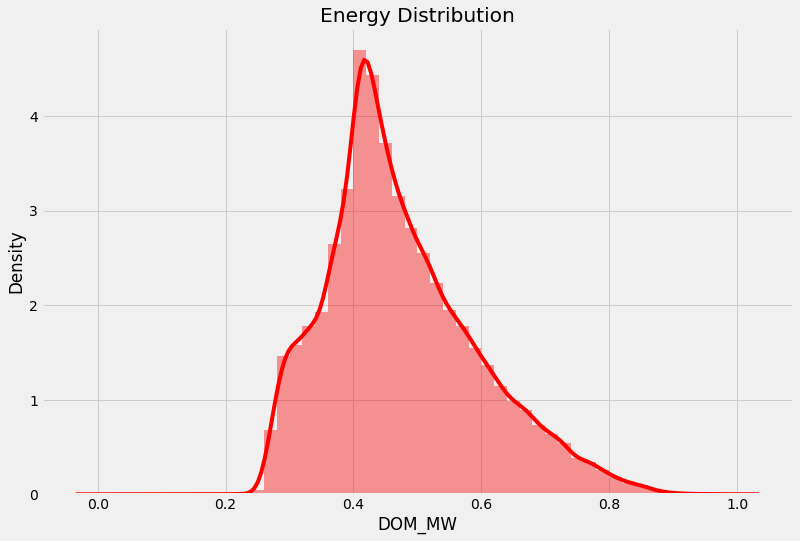

In [53]:
sns.distplot(df["DOM_MW"],color = 'r')
plt.title("Energy Distribution")